# Wiring the lightbulbs

You are tasked with wiring lightbulbs in a large warehouse. The location of the lightbulbs are listed below (in the (x,y) coordinates in meters). What is the minimum length of wire we need to make sure that all the bulbs are somehow connected to the breaker which is located at the (0,0).

Do not think too much about the circuit (or the return wire). We need to just connect the bulbs similar to the picture below. Assume that you need only a single wire running.

![Image of subgraph](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Minimum_spanning_tree.svg/600px-Minimum_spanning_tree.svg.png)













In [362]:
## location in (x,y)

light_bulb_locations = [(1.2,1.2),
                       (3.0,4.0),
                       (5.0,4.5),
                       (4.0,5.0),
                       (0.5,0.1),
                       (0.3,5.0),
                       (5.0,5.0),
                       (2.0,3.7),
                       (0.5,3.0),
                       (1.0,3.0)]

# add breaker location (0, 0)
light_bulb_locations=[(0.0, 0.0)]+light_bulb_locations
light_bulb_locations

[(0.0, 0.0),
 (1.2, 1.2),
 (3.0, 4.0),
 (5.0, 4.5),
 (4.0, 5.0),
 (0.5, 0.1),
 (0.3, 5.0),
 (5.0, 5.0),
 (2.0, 3.7),
 (0.5, 3.0),
 (1.0, 3.0)]

In [363]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import pulp
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value
import networkx as nx

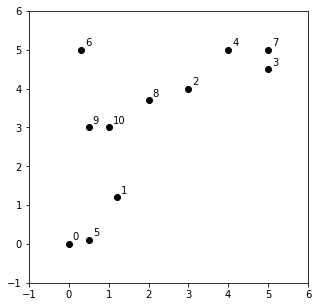

In [364]:
### useful code for plotting bulbs locations

plt.figure(figsize=(5, 5))

# draw problem state
for i, value in enumerate(light_bulb_locations):
    plt.scatter(value[0], value[1], c='black')
    plt.text(value[0]+0.1, value[1]+0.1, f'{i}')
        
plt.xlim([-1, 6])
plt.ylim([-1, 6])

### might be useful for drawing lines connecting dots

#plt.annotate('', xy=[light_bulb_locations[j][0], light_bulb_locations[j][1]], xytext=[light_bulb_locations[i][0], light_bulb_locations[i][1]], arrowprops=arrowprops)

plt.show()

In [365]:
d=distance_matrix(light_bulb_locations, light_bulb_locations, p=2)  # euclidean distance
d[0][5]

0.5099019513592785

In [395]:
model=LpProblem(name='mst', sense=LpMinimize)

In [396]:
x=LpVariable.dicts('x', ((i, j) for i in range(len(light_bulb_locations)) for j in range(len(light_bulb_locations)) if i!=j), cat='Binary')

In [397]:
# constraint
for i in range(len(light_bulb_locations)):
    # each node has at least 1 connected to other
    model+=lpSum(x[i, j]+x[j, i] for j in range(len(light_bulb_locations)) if i!=j) >= 1
    
for i in range(len(light_bulb_locations)):
    for j in range(len(light_bulb_locations)):
        if i!=j:
            model+=(x[i, j]+x[j, i] <= 1)  # undirected graph, select only 1 way a->b or b->a

# number of edges in MST = number of nodes - 1
model+=lpSum(x[i, j] for i in range(len(light_bulb_locations)) for j in range(len(light_bulb_locations)) if i!=j) == len(light_bulb_locations)-1

In [398]:
# objective function
model+=lpSum(x[i, j]*d[i][j] for i in range(len(light_bulb_locations)) for j in range(len(light_bulb_locations)) if i!=j)

In [399]:
model.solve()
LpStatus[model.status]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/panithi/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1e010014bf9840bba2282a7b3c84a4f2-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/1e010014bf9840bba2282a7b3c84a4f2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 127 COLUMNS
At line 1008 RHS
At line 1131 BOUNDS
At line 1242 ENDATA
Problem MODEL has 122 rows, 110 columns and 550 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10.6207 - 0.00 seconds
Cgl0004I processed model has 12 rows, 55 columns (55 integer (55 of which binary)) and 165 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 10.6207
Cbc0038I Before mini branch and bound, 55 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)


'Optimal'

In [400]:
print(model.objective.value())

10.620651320211401


In [401]:
from ast import literal_eval as make_tuple

wiring=[]
for var in model.variables():
    if var.name[0] == 'x' and var.value() == 1:
        print(var.name, var.value())
        a=var.name.replace('_', '')
        wiring.append(make_tuple(a[1:]))
    elif var.name[0] == 'u':
        print(var.name, var.value())
        
#wiring

x_(1,_5) 1.0
x_(10,_8) 1.0
x_(10,_9) 1.0
x_(2,_4) 1.0
x_(2,_8) 1.0
x_(3,_4) 1.0
x_(5,_0) 1.0
x_(7,_3) 1.0
x_(7,_4) 1.0
x_(9,_6) 1.0


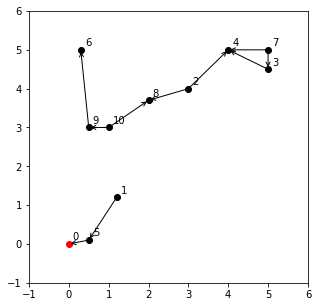

In [402]:
plt.figure(figsize=(5, 5))

# draw problem state
for i, value in enumerate(light_bulb_locations):
    if value[0]==0 and value[1]==0:
        plt.scatter(value[0], value[1], c='red')
    else:
        plt.scatter(value[0], value[1], c='black')
    plt.text(value[0]+0.1, value[1]+0.1, f'{i}')
        
plt.xlim([-1, 6])
plt.ylim([-1, 6])

### might be useful for drawing lines connecting dots

arrowprops=dict(arrowstyle='->')
for i, j in wiring:
    plt.annotate('', xy=[light_bulb_locations[j][0], light_bulb_locations[j][1]], xytext=[light_bulb_locations[i][0], light_bulb_locations[i][1]], arrowprops=arrowprops)

plt.show()

has subgraph
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/panithi/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/df501ba3117e4711a1b84e08d2069b30-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/df501ba3117e4711a1b84e08d2069b30-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 129 COLUMNS
At line 1072 RHS
At line 1197 BOUNDS
At line 1308 ENDATA
Problem MODEL has 124 rows, 110 columns and 612 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 11.0175 - 0.00 seconds
Cgl0004I processed model has 14 rows, 55 columns (55 integer (55 of which binary)) and 196 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 11.0175
Cbc0038I Before mini branch and bound, 55 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0

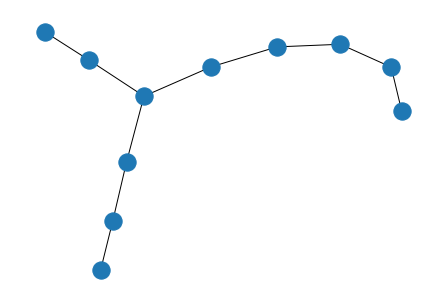

In [403]:
G=nx.Graph()
G.add_nodes_from(range(len(light_bulb_locations)))
for e in wiring:
    G.add_edge(e[0], e[1])
# eliminate subtours
while nx.number_connected_components(G) > 1:
    print('has subgraph')

    components=nx.connected_components(G)
    for c in components:
        #print(c)
        model+=lpSum(x[i, j] for i in c for j in c if i!=j) <= len(c)-1
        
    model.solve()
    wiring.clear()
    for var in model.variables():
        if var.name[0] == 'x' and var.value() == 1:
            print(var.name, var.value())
            a=var.name.replace('_', '')
            wiring.append(make_tuple(a[1:]))
        elif var.name[0] == 'u':
            print(var.name, var.value())
    G=nx.Graph()
    G.add_nodes_from(range(len(light_bulb_locations)))
    for e in wiring:
        G.add_edge(e[0], e[1])
            
print('no subgraph')
nx.draw(G)
print(model.objective.value())

#### Repeat the previous question. However, in this case there is another breaker that we can also use located at (6.0,5.0). What would be the minimum total length of the wire that we need?

In [404]:
light_bulb_locations=light_bulb_locations+[(6.0, 5.0)]
light_bulb_locations

[(0.0, 0.0),
 (1.2, 1.2),
 (3.0, 4.0),
 (5.0, 4.5),
 (4.0, 5.0),
 (0.5, 0.1),
 (0.3, 5.0),
 (5.0, 5.0),
 (2.0, 3.7),
 (0.5, 3.0),
 (1.0, 3.0),
 (6.0, 5.0)]

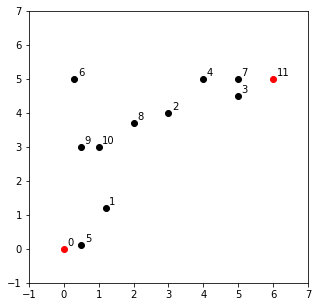

In [405]:
plt.figure(figsize=(5, 5))

for i, value in enumerate(light_bulb_locations):
    if (value[0]==0 and value[1]==0) or (value[0]==6 and value[1]==5):
        plt.scatter(value[0], value[1], c='red')
    else:
        plt.scatter(value[0], value[1], c='black')
    plt.text(value[0]+0.1, value[1]+0.1, f'{i}')
        
plt.xlim([-1, 7])
plt.ylim([-1, 7])

plt.show()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/panithi/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/3501cf94c0cd498290958ec14140d8c0-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/3501cf94c0cd498290958ec14140d8c0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 150 COLUMNS
At line 1207 RHS
At line 1353 BOUNDS
At line 1486 ENDATA
Problem MODEL has 145 rows, 132 columns and 660 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 11.3245 - 0.00 seconds
Cgl0004I processed model has 13 rows, 66 columns (66 integer (66 of which binary)) and 198 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 11.3245
Cbc0038I Before mini branch and bound, 66 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)


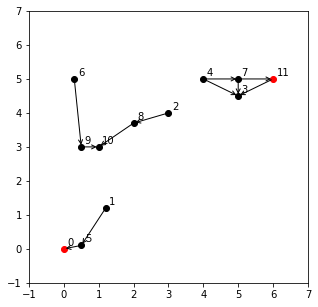

In [406]:
d=distance_matrix(light_bulb_locations, light_bulb_locations, p=2)  # euclidean distance
model=LpProblem(name='mst_2', sense=LpMinimize)
x=LpVariable.dicts('x', ((i, j) for i in range(len(light_bulb_locations)) for j in range(len(light_bulb_locations)) if i!=j), cat='Binary')
# constraint
for i in range(len(light_bulb_locations)):
    model+=lpSum(x[i, j]+x[j, i] for j in range(len(light_bulb_locations)) if i!=j) >= 1
for i in range(len(light_bulb_locations)):
    for j in range(len(light_bulb_locations)):
        if i!=j:
            model+=(x[i, j]+x[j, i] <= 1)  # select only 1 way

model+=lpSum(x[i, j] for i in range(len(light_bulb_locations)) for j in range(len(light_bulb_locations)) if i!=j) == len(light_bulb_locations)-1
# objective function
model+=lpSum(x[i, j]*d[i][j] for i in range(len(light_bulb_locations)) for j in range(len(light_bulb_locations)) if i!=j)
model.solve()
print(LpStatus[model.status])

wiring=[]
for var in model.variables():
    if var.name[0] == 'x' and var.value() == 1:
        print(var.name, var.value())
        a=var.name.replace('_', '')
        wiring.append(make_tuple(a[1:]))
    elif var.name[0] == 'u':
        print(var.name, var.value())
    

plt.figure(figsize=(5, 5))
for i, value in enumerate(light_bulb_locations):
    if (value[0]==0 and value[1]==0) or (value[0]==6 and value[1]==5):
        plt.scatter(value[0], value[1], c='red')
    else:
        plt.scatter(value[0], value[1], c='black')
    plt.text(value[0]+0.1, value[1]+0.1, f'{i}')
        
plt.xlim([-1, 7])
plt.ylim([-1, 7])

arrowprops=dict(arrowstyle='->')
for i, j in wiring:
    plt.annotate('', xy=[light_bulb_locations[j][0], light_bulb_locations[j][1]], xytext=[light_bulb_locations[i][0], light_bulb_locations[i][1]], arrowprops=arrowprops)

plt.show()

has subgraph
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/panithi/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/324a428724b1437e84a69bf2e38a803d-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/324a428724b1437e84a69bf2e38a803d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 153 COLUMNS
At line 1248 RHS
At line 1397 BOUNDS
At line 1530 ENDATA
Problem MODEL has 148 rows, 132 columns and 698 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.3137 - 0.00 seconds
Cgl0004I processed model has 16 rows, 66 columns (66 integer (66 of which binary)) and 217 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 12.3137
Cbc0038I Before mini branch and bound, 66 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0

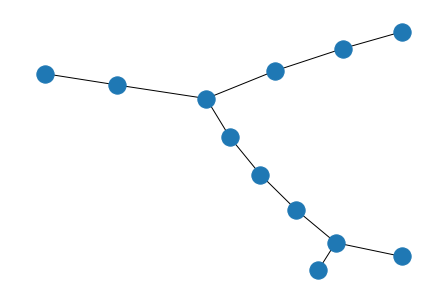

In [407]:
G=nx.Graph()
G.add_nodes_from(range(len(light_bulb_locations)))
for e in wiring:
    G.add_edge(e[0], e[1])
# eliminate subtours
while nx.number_connected_components(G) > 1:
    print('has subgraph')

    components=nx.connected_components(G)
    for c in components:
        #print(c)
        model+=lpSum(x[i, j] for i in c for j in c if i!=j) <= len(c)-1
        
    model.solve()
    wiring.clear()
    for var in model.variables():
        if var.name[0] == 'x' and var.value() == 1:
            print(var.name, var.value())
            a=var.name.replace('_', '')
            wiring.append(make_tuple(a[1:]))
        elif var.name[0] == 'u':
            print(var.name, var.value())
    G=nx.Graph()
    G.add_nodes_from(range(len(light_bulb_locations)))
    for e in wiring:
        G.add_edge(e[0], e[1])
            
print('no subgraph')
nx.draw(G)
print(model.objective.value())

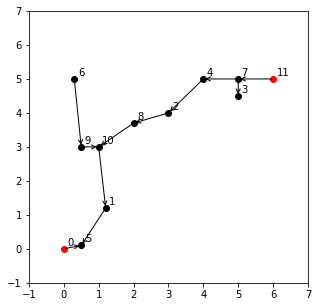

In [408]:
plt.figure(figsize=(5, 5))
for i, value in enumerate(light_bulb_locations):
    if (value[0]==0 and value[1]==0) or (value[0]==6 and value[1]==5):
        plt.scatter(value[0], value[1], c='red')
    else:
        plt.scatter(value[0], value[1], c='black')
    plt.text(value[0]+0.1, value[1]+0.1, f'{i}')
        
plt.xlim([-1, 7])
plt.ylim([-1, 7])

arrowprops=dict(arrowstyle='->')
for i, j in wiring:
    plt.annotate('', xy=[light_bulb_locations[j][0], light_bulb_locations[j][1]], xytext=[light_bulb_locations[i][0], light_bulb_locations[i][1]], arrowprops=arrowprops)

plt.show()